# Polarization behaviors on Twitter : temporal analysis

In this notebook, the following steps are performed:
* Definition of studied time frames
* Computation of polarization factors over each time frame
* Computation of polarization scores (GRAIL) over each time frame
* Identification and characterization of behavioral classes over each time frame
* Identification of polarization dynamics

# Libraries import

In [95]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import os
from mpl_toolkits.mplot3d import Axes3D
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from datetime import datetime, date, timedelta
from scipy.stats import entropy
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import davies_bouldin_score
import matplotlib.cm as cm
from tqdm import tnrange, tqdm_notebook
import itertools
import statsmodels.api as sm
from tslearn.utils import to_time_series
from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import silhouette_score
from sklearn.linear_model import LinearRegression
from pydlc import dense_lines

# Data import

In [2]:
#Vaccine debate 
# edges = pd.read_csv('data/interactions_vaccine_debate.csv', index_col=0)
# factors_data = pd.read_csv('data/indicators_vaccine_debate.csv', index_col=0)

#Ukraine conflict debate
edges = pd.read_csv('data/interactions_ukraine_debate.csv', index_col=0)
factors_data = pd.read_csv('data/temporal_indicators_ukraine_debate.csv', index_col=0)

In [3]:
retweeters = edges['Source'].unique().tolist()

In [4]:
#Create lists with identifier of elite users of each community
# provax_usernames = edges[edges['Side']=='provax']['Target'].unique().tolist()
# antivax_usernames = edges[edges['Side']=='antivax']['Target'].unique().tolist()

prorussia_usernames = edges[edges['Side']=='prorussia']['Target'].unique().tolist()
proukraine_usernames = edges[edges['Side']=='proukraine']['Target'].unique().tolist()

In [5]:
#vaccine_usernames = provax_usernames + antivax_usernames
war_usernames = prorussia_usernames + proukraine_usernames

# Time frames definition

In [6]:
edges['Timeset'] = pd.to_datetime(edges['Timeset'], infer_datetime_format=True)

## Périodes

In [7]:
def get_timeframes(w,c):
    start_date = pd.Timestamp('2022-01-01 00:00:00')
    end_date = pd.Timestamp('2022-01-01 00:00:00')
    last_date = pd.Timestamp('2022-07-31 23:59:39')
    list_periods = []
    while end_date < last_date:
        end_date = start_date + timedelta(weeks=w) +timedelta(hours=23) + timedelta(minutes=59)+ timedelta(seconds=59)
        list_periods.append([start_date, end_date])
        if (w==c):
            start_date = start_date + timedelta(weeks=c) + timedelta(days=1)
        else:
            start_date = start_date + timedelta(weeks=c)
    list_periods[-1][1] = last_date
    return list_periods

In [8]:
periods = get_timeframes(4,2)

In [9]:
periods

[[Timestamp('2022-01-01 00:00:00'), Timestamp('2022-01-29 23:59:59')],
 [Timestamp('2022-01-15 00:00:00'), Timestamp('2022-02-12 23:59:59')],
 [Timestamp('2022-01-29 00:00:00'), Timestamp('2022-02-26 23:59:59')],
 [Timestamp('2022-02-12 00:00:00'), Timestamp('2022-03-12 23:59:59')],
 [Timestamp('2022-02-26 00:00:00'), Timestamp('2022-03-26 23:59:59')],
 [Timestamp('2022-03-12 00:00:00'), Timestamp('2022-04-09 23:59:59')],
 [Timestamp('2022-03-26 00:00:00'), Timestamp('2022-04-23 23:59:59')],
 [Timestamp('2022-04-09 00:00:00'), Timestamp('2022-05-07 23:59:59')],
 [Timestamp('2022-04-23 00:00:00'), Timestamp('2022-05-21 23:59:59')],
 [Timestamp('2022-05-07 00:00:00'), Timestamp('2022-06-04 23:59:59')],
 [Timestamp('2022-05-21 00:00:00'), Timestamp('2022-06-18 23:59:59')],
 [Timestamp('2022-06-04 00:00:00'), Timestamp('2022-07-02 23:59:59')],
 [Timestamp('2022-06-18 00:00:00'), Timestamp('2022-07-16 23:59:59')],
 [Timestamp('2022-07-02 00:00:00'), Timestamp('2022-07-30 23:59:59')],
 [Time

# Polarization factors computation on each time frame

In [10]:
standard_users = edges['Source'].unique().tolist()
elite_users = edges['Target'].unique().tolist()

In [11]:
def get_distributions(periods, comm_1, comm_2, comm_1_usernames, comm_2_usernames):
    df_distri_communities = pd.DataFrame(columns=standard_users)
    df_distri_comm1 = pd.DataFrame(columns=standard_users)
    df_distri_comm2 = pd.DataFrame(columns=standard_users)
    
    for i in tqdm(range(len(periods))):
        edges_period = edges[(edges['Timeset']>= periods[i][0]) & (edges['Timeset']<= periods[i][1])]
        
        df_interactions_period = pd.DataFrame(columns=elite_users, index=standard_users)
        df_interactions_period = pd.crosstab(edges_period['Source'], edges_period['Target']).reindex(index=standard_users, columns=elite_users, fill_value=0)
        
        df_interactions_comm1_period = df_interactions_period[comm_1_usernames]
        df_interactions_comm2_period = df_interactions_period[comm_2_usernames]


        distri_sources_period = df_interactions_period.div(df_interactions_period.sum(axis=1), axis=0)
        distri_sources_comm1_period = df_interactions_comm1_period.div(df_interactions_comm1_period.sum(axis=1), axis=0)
        distri_sources_comm2_period = df_interactions_comm2_period.div(df_interactions_comm2_period.sum(axis=1), axis=0)
        
        #distri_communities_period = pd.DataFrame({comm_1:distri_sources_comm1_period.sum(axis=1).to_list(), comm_2:distri_sources_comm2_period.sum(axis=1).to_list()}, index=standard_users)
        distri_communities_period = pd.DataFrame({comm_1: df_interactions_comm1_period.sum(axis=1)/df_interactions_period.sum(axis=1).to_list(), comm_2:df_interactions_comm2_period.sum(axis=1)/df_interactions_period.sum(axis=1).to_list()})

        for j in tqdm(range(len(standard_users))):
            df_distri_communities.loc[i,standard_users[j]] = distri_communities_period.loc[standard_users[j]].tolist()
            if df_distri_communities.loc[i,standard_users[j]] == [0.0, 0.0] :
                df_distri_communities.loc[i,standard_users[j]] = np.nan

            df_distri_comm1.loc[i,standard_users[j]] = distri_sources_comm1_period.loc[standard_users[j]].tolist() 

            df_distri_comm2.loc[i,standard_users[j]] = distri_sources_comm2_period.loc[standard_users[j]].tolist()
            
    return df_distri_communities, df_distri_comm1, df_distri_comm2

In [12]:
#distri_comm, distri_sources_comm1, distri_sources_comm2 = get_distributions(periods, 'provax', 'antivax', provax_usernames, antivax_usernames)
distri_comm, distri_sources_comm1, distri_sources_comm2 = get_distributions(periods, 'proukraine', 'prorussia', proukraine_usernames, prorussia_usernames)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


In [13]:
distri_comm = distri_comm.astype(str)
distri_sources_comm1 = distri_sources_comm1.astype(str)
distri_sources_comm2 = distri_sources_comm2.astype(str)

## Pre-processing of data

In [14]:
def normalized_entropy(distribution):
    return entropy(distribution, base=2)/np.log2(len(distribution))

In [15]:
def complete_nan(df):
    df = df.replace(regex=r'nan', value=np.nan)
    df = df.fillna(method='bfill')
    df = df.fillna(method='ffill')
    return df

In [16]:
def complete_nan_by_zeros(df):
    df = df.replace(regex=r'nan', value=np.nan)
    df = df.fillna(value= '[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]')
    return df

In [17]:
#Convert each element of df to list, and each of element of list to float
def convert_str_to_list(string):
    if type(string) == str: 
        return [float(i) for i in string.strip('][').split(', ')]
    else:
        return(string)

In [18]:
#Identification of users with less than 3 inactive time frames
sum_users = 0
list_users = []
for u in standard_users:
    if distri_comm[u].replace(regex=r'nan', value=np.nan).isna().sum() >= 3:
        sum_users = sum_users + 1
    else:
        list_users.append(u)

In [19]:
distri_comm = distri_comm[list_users]
distri_sources_comm1 = distri_sources_comm1[list_users]
distri_sources_comm2 = distri_sources_comm2[list_users]

In [20]:
distri_comm = complete_nan(distri_comm)

In [21]:
distri_sources_comm1 = complete_nan_by_zeros(distri_sources_comm1)
distri_sources_comm2 = complete_nan_by_zeros(distri_sources_comm2)

In [22]:
distri_comm = distri_comm.applymap(convert_str_to_list)
distri_sources_comm1 = distri_sources_comm1.applymap(convert_str_to_list)
distri_sources_comm2 = distri_sources_comm2.applymap(convert_str_to_list)

In [23]:
#Calcul des distributions sur périodes cumulées

#1 : création d'un dataframe vide, qui va être rempli avec les nouvelles distributions de probabilité
cumul_distri_comm = pd.DataFrame(columns=distri_comm.columns, index=distri_comm.index)
cumul_distri_comm1 = pd.DataFrame(columns=distri_sources_comm1.columns, index=distri_sources_comm1.index)
cumul_distri_comm2 = pd.DataFrame(columns=distri_sources_comm2.columns, index=distri_sources_comm2.index)

#2 : OPINIONS > calcul des distributions pour chaque utilisateur 
for i in tqdm(range(cumul_distri_comm.shape[1])):
    for j in range(len(distri_comm)): 
        if j == 0:
            cumul_distri_comm.iloc[j,i] = distri_comm.iloc[j,i]
        else:
            cumul_distri_comm.iloc[j,i] = [sum(x)/2 for x in zip(cumul_distri_comm.iloc[j-1,i], distri_comm.iloc[j,i])]


#3a: calcul des distributions pour chaque utilisateur - communauté 1
for i in tqdm(range(distri_sources_comm1.shape[1])):
    for j in range(len(distri_sources_comm1)): 
        if j == 0:
            cumul_distri_comm1.iloc[j,i] = distri_sources_comm1.iloc[j,i]
        else:
            if cumul_distri_comm1.iloc[j-1,i] == [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]:
                cumul_distri_comm1.iloc[j,i] = distri_sources_comm1.iloc[j,i]
            else:
                cumul_distri_comm1.iloc[j,i] = [sum(x)/2 for x in zip(cumul_distri_comm1.iloc[j-1,i], distri_sources_comm1.iloc[j,i])]

#4b: calcul des distributions pour chaque utilisateur - communauté 2
for i in tqdm(range(distri_sources_comm2.shape[1])):
    for j in range(len(distri_sources_comm2)): 
        if j == 0:
            cumul_distri_comm2.iloc[j,i] = distri_sources_comm2.iloc[j,i]
        else:
            if cumul_distri_comm2.iloc[j-1,i] == [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]:
                cumul_distri_comm2.iloc[j,i] = distri_sources_comm2.iloc[j,i]
            else:
                cumul_distri_comm2.iloc[j,i] = [sum(x)/2 for x in zip(cumul_distri_comm2.iloc[j-1,i], distri_sources_comm2.iloc[j,i])]

 28%|██▊       | 221/784 [00:00<00:01, 369.57it/s]

100%|██████████| 784/784 [00:01<00:00, 429.30it/s]


## Computation


In [24]:
#OPINIONS
H_comm_cumul = 1 - cumul_distri_comm.applymap(normalized_entropy)
#Orientation
H_comm_cumul_oriented = H_comm_cumul.copy(deep=True)
for i in tqdm(range(cumul_distri_comm.shape[1])):
    for j in range(cumul_distri_comm.shape[0]):
        if cumul_distri_comm.iloc[j,i][0] >= cumul_distri_comm.iloc[j,i][1]:
             H_comm_cumul_oriented.iloc[j,i] = H_comm_cumul_oriented.iloc[j,i] #On ne change pas le signe
        elif cumul_distri_comm.iloc[j,i][0] < cumul_distri_comm.iloc[j,i][1]:
             H_comm_cumul_oriented.iloc[j,i] = -H_comm_cumul_oriented.iloc[j,i] #On change le signe


#SOURCES
H_sources1_cumul = 1-cumul_distri_comm1.applymap(normalized_entropy)
H_sources2_cumul = 1-cumul_distri_comm2.applymap(normalized_entropy)

100%|██████████| 784/784 [00:01<00:00, 448.86it/s]
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


In [25]:
H_sources1_cumul = H_sources1_cumul.fillna(0)
H_sources2_cumul = H_sources2_cumul.fillna(0)

In [38]:
def transform(x):
    return (x+1)/2

In [39]:
H_comm_cumul_trans = H_comm_cumul_oriented.applymap(transform)

# GRAIL computation over each time frame

In [26]:
#Vaccine
#a = 1/2

#Ukraine
a = 1/3

x_term = H_comm_cumul.transform(lambda x: (x**(a)/(x**(a)+(1-x)**(a)))) #application de la transformation sur terme X (utilisation des valeurs absolues), a=3
y_term_pro = H_sources1_cumul.transform(lambda x: (x**(a)/(x**(a)+(1-x)**(a))))
y_term_anti = H_sources2_cumul.transform(lambda x: (x**(a)/(x**(a)+(1-x)**(a))))

In [29]:
retweeters = list_users

In [30]:
alpha_comm = 0.6

GRAIL = pd.DataFrame(columns=H_comm_cumul.columns, index = H_comm_cumul.index)
for i in tqdm(range(len(retweeters))):
    for j in range(len(H_comm_cumul)):
        w1 = distri_comm.loc[j, retweeters[i]][0]
        w2 = distri_comm.loc[j, retweeters[i]][1]

        if ((w1 > 0) and (w2 > 0)):
            alpha_sources_C1 = (1-alpha_comm)/2
            alpha_sources_C2 = (1-alpha_comm)/2
        elif ((w1 > 0) and (w2 == 0)):
            alpha_sources_C1 = (1-alpha_comm)
            alpha_sources_C2 = 0
        elif ((w1 == 0) and (w2 > 0)):
            alpha_sources_C1 = 0
            alpha_sources_C2 = (1-alpha_comm)

        GRAIL_user = alpha_comm*x_term.loc[j, retweeters[i]] + alpha_sources_C1*y_term_pro.loc[j, retweeters[i]] + alpha_sources_C2*y_term_anti.loc[j, retweeters[i]]

        if w2 > w1:
            GRAIL_user = -GRAIL_user
        
        GRAIL.loc[j, retweeters[i]] = GRAIL_user

  9%|▉         | 73/784 [00:00<00:00, 729.30it/s]

100%|██████████| 784/784 [00:01<00:00, 611.97it/s]


In [31]:
GRAIL.head()

S1U       S2U       S3U       S4U       S5U  S6U       S7U       S8U  \
0 -1.0 -0.787276      -1.0 -0.831802 -0.823556 -1.0 -0.836861      -1.0   
1 -1.0  -0.77971      -1.0  -0.80615 -0.790957 -1.0 -0.841024      -1.0   
2 -1.0 -0.783256 -0.915477 -0.803978 -0.789243 -1.0 -0.820662      -1.0   
3 -1.0  -0.79037 -0.876555 -0.801363  -0.79019 -1.0 -0.808679  -0.91278   
4 -1.0 -0.795215 -0.872717 -0.801815 -0.781416 -1.0 -0.804206 -0.895465   

       S10U      S12U  ...     S979U     S981U     S983U     S986U     S988U  \
0      -1.0 -0.846265  ...       0.6  0.827897       0.6       0.6       0.6   
1      -1.0 -0.839165  ...       1.0  0.810321       1.0  0.842074       0.6   
2 -0.892277 -0.831394  ...  0.853081  0.648614  0.799259  0.840863  0.831802   
3 -0.881062 -0.834872  ...  0.628029  0.651208  0.790574  0.840288  0.805649   
4 -0.868427 -0.842516  ...  0.603788  0.575407  0.796446   0.84569  0.793185   

      S990U     S996U     S997U     S998U     S999U  
0       1.0       1.0       1.0       0.6       0.6  
1  0.837217       1.0       1.0       0.6       0.6  
2  0.804005  0.831624  0.869638       1.0       1.0  
3  0.794204  0.808763  0.855164  0.848742  0.857451  
4  0.791402  0.805873  0.828306  0.819507  0.847964  

[5 rows x 784 columns]

# Temporal analysis - polarization behaviors on each time frame

## Necessary functions

In [33]:
def optimal_k_means(X):
    res = pd.DataFrame(columns=['k','Silhouette_index','DaviesBouldin_index'])
    for k in (range(2, 13, 1)):
        model = KMeans(n_clusters=k)
        model.fit_predict(X)
        db = davies_bouldin_score(X, model.labels_)
        silhouette_avg = silhouette_score(X, model.labels_)
        res = res.append({'k':k, 'Silhouette_index': silhouette_avg, 'DaviesBouldin_index':db}, ignore_index=True)  
    #print(res)
    return res

In [34]:
def apply_k_means(X, k_opt):
    model = KMeans(n_clusters=k_opt)
    model.fit_predict(X)

    cluster_labels = model.labels_
    centers = pd.DataFrame(data=model.cluster_centers_, columns=X.columns)
    clusters = pd.DataFrame(centers, columns = X.columns)

    labels_df = pd.DataFrame(model.labels_.tolist(), columns=['Cluster'])
    size_clusters = labels_df.groupby('Cluster').size()
    size_clusters = size_clusters.to_frame()
    size_clusters.columns=['size']
    sizes = size_clusters['size'].tolist()
    clusters['size'] = sizes
    cols = clusters.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    clusters = clusters[cols]
    clusters = clusters.round(2)
    clusters = clusters.T

    return cluster_labels, centers, clusters

In [35]:
def get_silhouette_plot(X, k_opt):
    model = KMeans(n_clusters=k_opt)
    model.fit_predict(X)
    DB = davies_bouldin_score(X, model.labels_)
    print('Davies Bouldin Index : ', DB)

    silhouette_avg = silhouette_score(X, model.labels_)
    print('Silhouette Index : ', silhouette_avg)

    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(12, 6)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (model.n_clusters + 1) * 10])

    sample_silhouette_values = silhouette_samples(X, model.labels_)
    y_lower = 10
    for i in range (model.n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[model.labels_ == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / model.n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                "with n_clusters = %d" % model.n_clusters),
                fontsize=14, fontweight='bold')

In [36]:
def plot_clusters(X, x, y, z, c):
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    from matplotlib.colors import ListedColormap
    ax.scatter(X[x], X[y], X[z], c=X[c], s= 120, cmap='tab10')

    ax.set_xlabel(x, fontsize='15', labelpad=10)
    ax.set_ylabel(y, fontsize='15', labelpad=10)
    ax.set_zlabel(z, fontsize='15', labelpad=10)

## Identification of behavioral classes

#### Tuning of the number of clusters $k$

In [41]:
#Vaccine
#a = 1/2

#Ukraine
a = 1/3

def f_sigmoid_optim(x):
    return(x**(a)/(x**(a)+(1-x)**(a)))

In [42]:
def periodic_optimal_kmeans(df_opinions, df_sources_C1, df_sources_C2, periods_df, alpha):
    optim_clustering_periods = pd.DataFrame(columns=df_opinions.index, index=['k', 'Silhouette', 'Davies-Bouldin'])
    df_opinions = df_opinions.apply(f_sigmoid_optim)
    df_sources_C1 = df_sources_C1.apply(f_sigmoid_optim)
    df_sources_C2 = df_sources_C2.apply(f_sigmoid_optim)

    for p in tqdm(range(len(periods_df))):
        X = pd.DataFrame(columns=['x', 'y_C1', 'y_C2'])
        X['x'] = alpha*df_opinions.iloc[p,:]
        X['y_C1'] = ((1-alpha)/2)*df_sources_C1.iloc[p,:]
        X['y_C2'] = ((1-alpha)/2)*df_sources_C2.iloc[p, :]
        res = optimal_k_means(X)
     
        optim_clustering_periods.loc['k',p] = res[res['Silhouette_index'] == res['Silhouette_index'].max()]['k'].values[0]
        optim_clustering_periods.loc['Silhouette',p] = res[res['Silhouette_index'] == res['Silhouette_index'].max()]['Silhouette_index'].values[0]
        optim_clustering_periods.loc['Davies-Bouldin', p] = res[res['Silhouette_index'] == res['Silhouette_index'].max()]['DaviesBouldin_index'].values[0]  

    return optim_clustering_periods

In [43]:
optim_k_means_periods = periodic_optimal_kmeans(H_comm_cumul_trans, H_sources1_cumul, H_sources2_cumul, periods, alpha=0.6)

  0%|          | 0/15 [00:00<?, ?it/s]C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/4238583414.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'k':k, 'Silhouette_index': silhouette_avg, 'DaviesBouldin_index':db}, ignore_index=True)
C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/4238583414.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'k':k, 'Silhouette_index': silhouette_avg, 'DaviesBouldin_index':db}, ignore_index=True)
C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/4238583414.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'k':k, 'Silhouette_index': silhouette_avg, 'DaviesBouldin_index':db}, ignore_index=True)
C:\Users\CTREU

In [44]:
optim_k_means_periods

0         1         2         3         4         5   \
k                    8.0       9.0       3.0       3.0       4.0       4.0   
Silhouette      0.948721  0.881146  0.868353  0.879587  0.883134  0.880706   
Davies-Bouldin  0.210164  0.407929  0.361571   0.38067  0.373713    0.3226   

                      6         7         8         9         10        11  \
k                    4.0       4.0       4.0       4.0       4.0       4.0   
Silhouette      0.879109  0.872341  0.868093  0.860138  0.853295  0.842333   
Davies-Bouldin  0.321672  0.358419  0.365608  0.371021  0.387871  0.402785   

                      12        13        14  
k                    4.0       2.0       2.0  
Silhouette      0.834112  0.834174  0.837156  
Davies-Bouldin  0.412823  0.248452  0.244339

### Clustering 

In [49]:
def periodic_kmeans(df_opinions, df_sources_C1, df_sources_C2, periods_df, alpha):
    clusters_periods = pd.DataFrame(index=['size','x', 'y_C1', 'y_C2'])
    clusters_users = pd.DataFrame(index=df_opinions.index, columns=df_opinions.columns)
    clusters_users_names = pd.DataFrame(index=df_opinions.index, columns=df_opinions.columns)

    df_opinions = df_opinions.apply(f_sigmoid_optim)
    df_sources_C1 = df_sources_C1.apply(f_sigmoid_optim)
    df_sources_C2 = df_sources_C2.apply(f_sigmoid_optim)

    for p in tqdm(range(len(periods))):
        X = pd.DataFrame(columns=['x', 'y_C1', 'y_C2'])

        X['x'] = alpha*(df_opinions.iloc[p,:])
        X['y_C1'] = ((1-alpha)/2)*(df_sources_C1.iloc[p,:])
        X['y_C2'] = ((1-alpha)/2)*(df_sources_C2.iloc[p, :])

        res = optimal_k_means(X)
        k_opt = int(res[res['Silhouette_index'] == res['Silhouette_index'].max()]['k'].values[0])


        labels, centers, clusters = apply_k_means(X, k_opt)

        sort_clusters = clusters.sort_values(by=['x','y_C1','y_C2'], ascending=False,axis=1)
        map = {}
        for i in range(k_opt):
            map[sort_clusters.columns[i]]=clusters.columns[i]
        labels_map = [map[i] for i in labels]

        clusters_users.loc[p, :] = labels_map
        clusters_final = clusters.sort_values(by=['x','y_C1','y_C2'], ascending=False, ignore_index=True,axis=1)


        for i in range(clusters_final.shape[1]):
            x_value = clusters_final.loc['x',i]
            if abs(0.6 - x_value) <= 0.05:
                clusters_final.loc['name',i] = 'proU'
            elif abs(0.0 - x_value) <= 0.05:
                clusters_final.loc['name',i] = 'proR'
            elif (0.25 <= x_value <= 0.35):
                clusters_final.loc['name',i] = 'inter'
            elif (abs(0.6 - x_value) >= 0.05) and (x_value > 0.35):
                clusters_final.loc['name',i] = 'interU'
            elif (abs(0.0 - x_value) >= 0.05) and (x_value < 0.25):
                clusters_final.loc['name',i] = 'interR'
        map_names = {}
        for i in range(clusters_final.shape[1]):
            map_names[i] = clusters_final.loc['name',i]
        
        labels_names = [map_names[i] for i in labels_map]
        clusters_users_names.loc[p, :] = labels_names

        for k in range(k_opt):
            name = 'P'+str(p)+'_C'+str(k)
            clusters_periods[name]=clusters_final.loc[:,k]

    return clusters_periods, clusters_users, clusters_users_names

In [50]:
k_means_periods, users_clusters_periods, users_clusters_periods_names = periodic_kmeans(H_comm_cumul_trans, H_sources1_cumul, H_sources2_cumul, periods, 0.6)

  0%|          | 0/15 [00:00<?, ?it/s]C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/4238583414.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'k':k, 'Silhouette_index': silhouette_avg, 'DaviesBouldin_index':db}, ignore_index=True)
C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/4238583414.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'k':k, 'Silhouette_index': silhouette_avg, 'DaviesBouldin_index':db}, ignore_index=True)
C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/4238583414.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'k':k, 'Silhouette_index': silhouette_avg, 'DaviesBouldin_index':db}, ignore_index=True)
C:\Users\CTREU

In [51]:
k_means_periods.head()

P0_C0 P0_C1  P0_C2 P0_C3 P0_C4  P0_C5  P0_C6 P0_C7  P1_C0  P1_C1  ...  \
size  124.0  68.0  143.0   7.0   7.0  165.0  194.0  76.0  145.0  102.0  ...   
x       0.6   0.6    0.6   0.3  0.29   -0.0   -0.0  -0.0    0.6    0.6  ...   
y_C1    0.2  0.11   -0.0   0.0  0.19   -0.0   -0.0  -0.0    0.2   0.11  ...   
y_C2    0.0  -0.0    0.0   0.0  0.14    0.2   0.12  -0.0    0.0    0.0  ...   

     P11_C2 P11_C3 P12_C0 P12_C1 P12_C2 P12_C3 P13_C0 P13_C1 P14_C0 P14_C1  
size  136.0  303.0  311.0   34.0  140.0  299.0  343.0  441.0  344.0  440.0  
x      0.11   -0.0    0.6   0.46    0.1    0.0   0.59   0.03   0.59   0.03  
y_C1   0.18    0.0   0.11   0.11   0.18    0.0   0.11   0.06   0.12   0.06  
y_C2   0.11   0.13    0.0   0.17   0.11   0.12   0.02   0.12   0.02   0.12  

[4 rows x 63 columns]

In [94]:
#lists of users Vaccine
# inter_users = []
# provax_users = []
# antivax_users = []
# for u in list_users:
#     if users_clusters_periods_names[u].eq('interPro').any() == True:
#         inter_users.append(u)
#     elif  users_clusters_periods_names[u].eq('interAnti').any() == True:
#         inter_users.append(u)
#     elif users_clusters_periods_names[u].eq('pro').all() == True:
#         provax_users.append(u)
#     elif users_clusters_periods_names[u].eq('anti').all() == True:
#         antivax_users.append(u)


#Lists of users Ukraine
inter_users = []
proU_users = []
proR_users = []
for u in list_users:
    if users_clusters_periods_names[u].eq('inter').any() == True:
        inter_users.append(u)
    if users_clusters_periods_names.loc[3, u] == 'proU':
        proU_users.append(u)
    if users_clusters_periods_names.loc[3, u] == 'proR':
        proR_users.append(u)

In [56]:
#Vaccine
#print('Number of intermediate users:', len(inter_users))
# print('Number of provax users:', len(provax_users))
# print('Number of antivax users:', len(antivax_users))

#Ukraine
print('Number of intermediate users:', len(inter_users))
print('Number of pro-Ukraine users:', len(proU_users))
print('Number of pro-Russia users:', len(proR_users))

Number of intermediate users: 76
Number of pro-Ukraine users: 317
Number of pro-Russia users: 391


## Characterization of identified behavioral classes

### Necessary functions

In [58]:
def ols_regression_optimization(ind_var,y):
    X = sm.add_constant(ind_var, prepend=False)
    
    # Note the difference in argument order
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X) # make the predictions by the model
    
    # Print out the statistics
    res = [("R_squared:", model.rsquared), ("R_squared_adjusted: ", model.rsquared_adj),
           ("F_value: ", model.fvalue), ("N_observations: ", model.nobs), 
           ("DF_model: ", model.df_model), ("DF_residuals: ", model.df_resid), 
           ("Coef: ", model.params), ("STD Err", model.bse), ("t values: ", model.tvalues), 
           ("p values", model.pvalues)]

    return model

In [59]:
def ols_regression(ind_var,y):

    X = sm.add_constant(ind_var, prepend=False)

    model = sm.OLS(y, X).fit()
    predictions = model.predict(X) # make the predictions by the model
    
    # Print out the statistics
    res = [("R_squared:", model.rsquared), ("R_squared_adjusted: ", model.rsquared_adj),
           ("F_value: ", model.fvalue), ("N_observations: ", model.nobs), 
           ("DF_model: ", model.df_model), ("DF_residuals: ", model.df_resid), 
           ("Coef: ", model.params), ("STD Err", model.bse), ("t values: ", model.tvalues), 
           ("p values", model.pvalues)]
    print(model.summary())

In [60]:
def optimization_OLS(df, ind_var, Y):
    factors_list = []
    R_squared_list = []
    for k in tnrange(1,len(list_factors) + 1):
        for combo in itertools.combinations(list_factors, k):
            factors_list.append(combo)
            model = ols_regression_optimization(df[list(combo)], Y)
            R_squared_list.append(model.rsquared)
    df_results = pd.DataFrame({'Factors':factors_list, 'R²':R_squared_list})
    
    # best_combination = list(df_results.sort_values(by='R²', ascending=False).head(1)['Factors'].values[0])
    # best_r_squared = df_results.sort_values(by='R²', ascending=False).head(1)['R²'].values[0]
    max_r2 = round(df_results['R²'].max(), 2)
    max_factors = df_results[df_results['R²'].round(2)==max_r2]
    max_factors = max_factors.reset_index(drop=True)

    list_combinations = []
    for i in range(max_factors.shape[0]):
        list_combinations.append(list(max_factors.loc[i,'Factors']))

    best_combination = min(list_combinations, key=len)
    best_r_squared = max_r2  
    
    print('Combinaison optimale :', best_combination, '\nNombre de facteurs :', len(best_combination), '\nR² max =', best_r_squared )
    return best_combination #, df_results

In [61]:
def optim_regression(df, n_cluster, value_grail, factors, get_details=False):
    cluster = df[df['cluster']==n_cluster]
    ind_var = cluster[factors]
    Y = cluster[value_grail]

    best_combination, results = optimization_OLS(cluster, ind_var, Y)
    
    if get_details == True:
        ind_var_optim = cluster[best_combination]
        for i in range(1, ind_var_optim.shape[1]+1):
            ols_regression(ind_var_optim.iloc[:,:i], cluster[value_grail])

    return best_combination, results

### Application RH

In [62]:
#Vaccine
#list_factors_complete = ['RT_vaccine','prop_vaccine_RTs','frequency_days','nb_mentors_provax','nb_mentors_antivax','Betweenness_centrality','Closeness_centrality','PageRank']

#Ukraine
list_factors_complete = ['RT_war','prop_war_RTs','frequency_days','nb_mentors_prorussia','nb_mentors_proukraine','Betweenness_centrality','Closeness_centrality','PageRank']


In [63]:
factors_data = factors_data[factors_data.index.isin(list_users)]

In [64]:
factors_data = factors_data.replace(np.nan, 0)

In [65]:
infos_periods = pd.DataFrame(columns=['user','period','cluster','GRAIL'])

for u in list_users:
    for p in range(len(periods)):
        row = {'user':u, 'period':p, 'cluster':users_clusters_periods.loc[p,u], 'GRAIL':GRAIL.loc[p,u]}
        infos_periods = infos_periods.append(row, ignore_index=True)

C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/3333365165.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infos_periods = infos_periods.append(row, ignore_index=True)
C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/3333365165.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infos_periods = infos_periods.append(row, ignore_index=True)
C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/3333365165.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infos_periods = infos_periods.append(row, ignore_index=True)
C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/3333365165.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

In [66]:
results_regression = pd.DataFrame(index=['R²_max','nb_factors','factors','coeffs','p_values','delta_R²'])

In [67]:
for p in tqdm(range(len(periods))):
    #Récupération des facteurs sur la période
    list_factors = []
    for f in list_factors_complete:
        name = f+'_P'+str(p)
        list_factors.append(name)
    factors_data_period = factors_data[list_factors]
    clusters_grail_period = infos_periods[infos_periods['period']==p].set_index('user',drop=True)

    complete_data_period = factors_data_period.merge(clusters_grail_period, right_index=True, left_index=True)
    #print(complete_data_period)
    #Nombre de clusters sur la période
    nb_clusters = users_clusters_periods.loc[p,:].nunique()

    for i in range(nb_clusters):
        #optim_regression(complete_data_period, i, 'GRAIL', list_factors, get_details=True)
        #print(model.rsquared)
        cluster = complete_data_period[complete_data_period['cluster']==i]
        ind_var = cluster[list_factors]
        Y = cluster['GRAIL']
        best_combination = optimization_OLS(cluster, ind_var, Y)
        print(best_combination)
        ind_var_optim = cluster[best_combination]

        #Récupération des valeurs de R² à chaque étape
        r_squared = []
        for j in range(1,ind_var_optim.shape[1]+1):
            X = sm.add_constant(ind_var_optim.iloc[:,:j], prepend=False)
            model = sm.OLS(Y,X).fit()
            predictions = model.predict(X)
            r_squared.append(model.rsquared.round(2))

        #Application RH global sur combinaison optimale de facteurs
        X = sm.add_constant(ind_var_optim, prepend=False)
        model = sm.OLS(Y, X).fit()
        predictions = model.predict(X)

        r_squared_max = model.rsquared
        coeffs = model.params.round(3).tolist()
        coeffs = coeffs[:-1]
        p_values = model.pvalues.round(2).tolist()
        p_values = p_values[:-1]

        results_regression['P'+str(p)+'_C'+str(i)] = None
        results_regression['P'+str(p)+'_C'+str(i)] = results_regression['P'+str(p)+'_C'+str(i)].astype('object') 

        results_regression.loc['R²_max','P'+str(p)+'_C'+str(i)] = r_squared_max
        results_regression.loc['nb_factors','P'+str(p)+'_C'+str(i)] = int(len(best_combination))
        results_regression.at['factors','P'+str(p)+'_C'+str(i)] = best_combination
        results_regression.at['coeffs','P'+str(p)+'_C'+str(i)] = coeffs
        results_regression.at['p_values','P'+str(p)+'_C'+str(i)] = p_values
        results_regression.at['delta_R²','P'+str(p)+'_C'+str(i)] = r_squared


  0%|          | 0/15 [00:00<?, ?it/s]C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1841: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.center

Combinaison optimale : ['RT_war_P0'] 
Nombre de facteurs : 1 
R² max = -inf
['RT_war_P0']


c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.cen

  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P0', 'frequency_days_P0', 'nb_mentors_proukraine_P0', 'PageRank_P0'] 
Nombre de facteurs : 4 
R² max = 0.93
['RT_war_P0', 'frequency_days_P0', 'nb_mentors_proukraine_P0', 'PageRank_P0']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P0'] 
Nombre de facteurs : 1 
R² max = 0.0
['RT_war_P0']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P0'] 
Nombre de facteurs : 1 
R² max = 0.0
['RT_war_P0']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1765: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1765: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1687: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1765: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1765: Runtim

Combinaison optimale : ['RT_war_P0', 'prop_war_RTs_P0', 'frequency_days_P0', 'nb_mentors_prorussia_P0', 'Closeness_centrality_P0'] 
Nombre de facteurs : 5 
R² max = 1.0
['RT_war_P0', 'prop_war_RTs_P0', 'frequency_days_P0', 'nb_mentors_prorussia_P0', 'Closeness_centrality_P0']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.cen

Combinaison optimale : ['RT_war_P0'] 
Nombre de facteurs : 1 
R² max = -inf
['RT_war_P0']


c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P0', 'frequency_days_P0', 'nb_mentors_prorussia_P0', 'PageRank_P0'] 
Nombre de facteurs : 4 
R² max = 0.92
['RT_war_P0', 'frequency_days_P0', 'nb_mentors_prorussia_P0', 'PageRank_P0']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.cen

Combinaison optimale : ['RT_war_P0'] 
Nombre de facteurs : 1 
R² max = -inf
['RT_war_P0']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.cen

Combinaison optimale : ['RT_war_P1'] 
Nombre de facteurs : 1 
R² max = -inf
['RT_war_P1']


c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.cen

  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P1', 'prop_war_RTs_P1', 'frequency_days_P1', 'nb_mentors_proukraine_P1', 'Betweenness_centrality_P1', 'Closeness_centrality_P1', 'PageRank_P1'] 
Nombre de facteurs : 7 
R² max = 0.58
['RT_war_P1', 'prop_war_RTs_P1', 'frequency_days_P1', 'nb_mentors_proukraine_P1', 'Betweenness_centrality_P1', 'Closeness_centrality_P1', 'PageRank_P1']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.cen

Combinaison optimale : ['RT_war_P1'] 
Nombre de facteurs : 1 
R² max = -inf
['RT_war_P1']


c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_fact

  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P1', 'nb_mentors_prorussia_P1'] 
Nombre de facteurs : 2 
R² max = 0.87
['RT_war_P1', 'nb_mentors_prorussia_P1']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P1'] 
Nombre de facteurs : 1 
R² max = 0.0
['RT_war_P1']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P1', 'prop_war_RTs_P1', 'frequency_days_P1', 'nb_mentors_prorussia_P1', 'nb_mentors_proukraine_P1', 'Closeness_centrality_P1', 'PageRank_P1'] 
Nombre de facteurs : 7 
R² max = 0.6
['RT_war_P1', 'prop_war_RTs_P1', 'frequency_days_P1', 'nb_mentors_prorussia_P1', 'nb_mentors_proukraine_P1', 'Closeness_centrality_P1', 'PageRank_P1']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P1', 'prop_war_RTs_P1', 'nb_mentors_prorussia_P1', 'Closeness_centrality_P1', 'PageRank_P1'] 
Nombre de facteurs : 5 
R² max = 0.93
['RT_war_P1', 'prop_war_RTs_P1', 'nb_mentors_prorussia_P1', 'Closeness_centrality_P1', 'PageRank_P1']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P1', 'frequency_days_P1', 'nb_mentors_prorussia_P1', 'PageRank_P1'] 
Nombre de facteurs : 4 
R² max = 0.72
['RT_war_P1', 'frequency_days_P1', 'nb_mentors_prorussia_P1', 'PageRank_P1']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ctreuill.BIDOUILLE\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.cen

Combinaison optimale : ['RT_war_P1'] 
Nombre de facteurs : 1 
R² max = -inf
['RT_war_P1']


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P2', 'prop_war_RTs_P2', 'frequency_days_P2', 'nb_mentors_proukraine_P2', 'Betweenness_centrality_P2', 'Closeness_centrality_P2'] 
Nombre de facteurs : 6 
R² max = 0.63
['RT_war_P2', 'prop_war_RTs_P2', 'frequency_days_P2', 'nb_mentors_proukraine_P2', 'Betweenness_centrality_P2', 'Closeness_centrality_P2']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P2', 'prop_war_RTs_P2', 'nb_mentors_prorussia_P2', 'nb_mentors_proukraine_P2', 'Closeness_centrality_P2', 'PageRank_P2'] 
Nombre de facteurs : 6 
R² max = 0.77
['RT_war_P2', 'prop_war_RTs_P2', 'nb_mentors_prorussia_P2', 'nb_mentors_proukraine_P2', 'Closeness_centrality_P2', 'PageRank_P2']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:41<02:29, 12.44s/it]

Combinaison optimale : ['RT_war_P2', 'prop_war_RTs_P2', 'nb_mentors_prorussia_P2'] 
Nombre de facteurs : 3 
R² max = 0.69
['RT_war_P2', 'prop_war_RTs_P2', 'nb_mentors_prorussia_P2']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P3', 'prop_war_RTs_P3', 'nb_mentors_proukraine_P3', 'Betweenness_centrality_P3', 'Closeness_centrality_P3', 'PageRank_P3'] 
Nombre de facteurs : 6 
R² max = 0.68
['RT_war_P3', 'prop_war_RTs_P3', 'nb_mentors_proukraine_P3', 'Betweenness_centrality_P3', 'Closeness_centrality_P3', 'PageRank_P3']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P3', 'prop_war_RTs_P3', 'frequency_days_P3', 'nb_mentors_prorussia_P3', 'nb_mentors_proukraine_P3', 'PageRank_P3'] 
Nombre de facteurs : 6 
R² max = 0.81
['RT_war_P3', 'prop_war_RTs_P3', 'frequency_days_P3', 'nb_mentors_prorussia_P3', 'nb_mentors_proukraine_P3', 'PageRank_P3']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

 27%|██▋       | 4/15 [00:46<01:46,  9.66s/it]

Combinaison optimale : ['RT_war_P3', 'prop_war_RTs_P3', 'nb_mentors_prorussia_P3', 'Closeness_centrality_P3', 'PageRank_P3'] 
Nombre de facteurs : 5 
R² max = 0.77
['RT_war_P3', 'prop_war_RTs_P3', 'nb_mentors_prorussia_P3', 'Closeness_centrality_P3', 'PageRank_P3']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P4', 'prop_war_RTs_P4', 'frequency_days_P4', 'nb_mentors_proukraine_P4', 'Betweenness_centrality_P4', 'Closeness_centrality_P4'] 
Nombre de facteurs : 6 
R² max = 0.62
['RT_war_P4', 'prop_war_RTs_P4', 'frequency_days_P4', 'nb_mentors_proukraine_P4', 'Betweenness_centrality_P4', 'Closeness_centrality_P4']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P4', 'prop_war_RTs_P4', 'frequency_days_P4', 'nb_mentors_prorussia_P4', 'nb_mentors_proukraine_P4', 'Betweenness_centrality_P4', 'Closeness_centrality_P4'] 
Nombre de facteurs : 7 
R² max = 0.45
['RT_war_P4', 'prop_war_RTs_P4', 'frequency_days_P4', 'nb_mentors_prorussia_P4', 'nb_mentors_proukraine_P4', 'Betweenness_centrality_P4', 'Closeness_centrality_P4']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P4', 'prop_war_RTs_P4', 'nb_mentors_prorussia_P4', 'nb_mentors_proukraine_P4', 'Betweenness_centrality_P4', 'Closeness_centrality_P4', 'PageRank_P4'] 
Nombre de facteurs : 7 
R² max = 0.54
['RT_war_P4', 'prop_war_RTs_P4', 'nb_mentors_prorussia_P4', 'nb_mentors_proukraine_P4', 'Betweenness_centrality_P4', 'Closeness_centrality_P4', 'PageRank_P4']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:52<01:21,  8.14s/it]

Combinaison optimale : ['RT_war_P4', 'prop_war_RTs_P4', 'nb_mentors_prorussia_P4', 'Betweenness_centrality_P4', 'Closeness_centrality_P4', 'PageRank_P4'] 
Nombre de facteurs : 6 
R² max = 0.81
['RT_war_P4', 'prop_war_RTs_P4', 'nb_mentors_prorussia_P4', 'Betweenness_centrality_P4', 'Closeness_centrality_P4', 'PageRank_P4']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P5', 'prop_war_RTs_P5', 'nb_mentors_proukraine_P5', 'PageRank_P5'] 
Nombre de facteurs : 4 
R² max = 0.59
['RT_war_P5', 'prop_war_RTs_P5', 'nb_mentors_proukraine_P5', 'PageRank_P5']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P5', 'prop_war_RTs_P5', 'frequency_days_P5', 'nb_mentors_prorussia_P5', 'nb_mentors_proukraine_P5', 'Betweenness_centrality_P5', 'Closeness_centrality_P5'] 
Nombre de facteurs : 7 
R² max = 0.41
['RT_war_P5', 'prop_war_RTs_P5', 'frequency_days_P5', 'nb_mentors_prorussia_P5', 'nb_mentors_proukraine_P5', 'Betweenness_centrality_P5', 'Closeness_centrality_P5']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P5', 'prop_war_RTs_P5', 'frequency_days_P5', 'nb_mentors_prorussia_P5', 'nb_mentors_proukraine_P5', 'PageRank_P5'] 
Nombre de facteurs : 6 
R² max = 0.63
['RT_war_P5', 'prop_war_RTs_P5', 'frequency_days_P5', 'nb_mentors_prorussia_P5', 'nb_mentors_proukraine_P5', 'PageRank_P5']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

 40%|████      | 6/15 [00:58<01:07,  7.55s/it]

Combinaison optimale : ['RT_war_P5', 'prop_war_RTs_P5', 'nb_mentors_prorussia_P5', 'Betweenness_centrality_P5', 'Closeness_centrality_P5', 'PageRank_P5'] 
Nombre de facteurs : 6 
R² max = 0.84
['RT_war_P5', 'prop_war_RTs_P5', 'nb_mentors_prorussia_P5', 'Betweenness_centrality_P5', 'Closeness_centrality_P5', 'PageRank_P5']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P6', 'prop_war_RTs_P6', 'frequency_days_P6', 'nb_mentors_proukraine_P6', 'Betweenness_centrality_P6', 'Closeness_centrality_P6', 'PageRank_P6'] 
Nombre de facteurs : 7 
R² max = 0.66
['RT_war_P6', 'prop_war_RTs_P6', 'frequency_days_P6', 'nb_mentors_proukraine_P6', 'Betweenness_centrality_P6', 'Closeness_centrality_P6', 'PageRank_P6']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P6', 'prop_war_RTs_P6', 'frequency_days_P6', 'nb_mentors_proukraine_P6', 'Closeness_centrality_P6', 'PageRank_P6'] 
Nombre de facteurs : 6 
R² max = 0.41
['RT_war_P6', 'prop_war_RTs_P6', 'frequency_days_P6', 'nb_mentors_proukraine_P6', 'Closeness_centrality_P6', 'PageRank_P6']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P6', 'prop_war_RTs_P6', 'nb_mentors_proukraine_P6', 'Closeness_centrality_P6', 'PageRank_P6'] 
Nombre de facteurs : 5 
R² max = 0.52
['RT_war_P6', 'prop_war_RTs_P6', 'nb_mentors_proukraine_P6', 'Closeness_centrality_P6', 'PageRank_P6']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

 47%|████▋     | 7/15 [01:06<01:00,  7.58s/it]

Combinaison optimale : ['RT_war_P6', 'prop_war_RTs_P6', 'frequency_days_P6', 'nb_mentors_prorussia_P6', 'Closeness_centrality_P6', 'PageRank_P6'] 
Nombre de facteurs : 6 
R² max = 0.81
['RT_war_P6', 'prop_war_RTs_P6', 'frequency_days_P6', 'nb_mentors_prorussia_P6', 'Closeness_centrality_P6', 'PageRank_P6']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P7', 'prop_war_RTs_P7', 'nb_mentors_proukraine_P7', 'PageRank_P7'] 
Nombre de facteurs : 4 
R² max = 0.63
['RT_war_P7', 'prop_war_RTs_P7', 'nb_mentors_proukraine_P7', 'PageRank_P7']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P7', 'prop_war_RTs_P7', 'frequency_days_P7', 'nb_mentors_prorussia_P7', 'Betweenness_centrality_P7', 'PageRank_P7'] 
Nombre de facteurs : 6 
R² max = 0.47
['RT_war_P7', 'prop_war_RTs_P7', 'frequency_days_P7', 'nb_mentors_prorussia_P7', 'Betweenness_centrality_P7', 'PageRank_P7']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P7', 'frequency_days_P7', 'nb_mentors_proukraine_P7', 'Closeness_centrality_P7', 'PageRank_P7'] 
Nombre de facteurs : 5 
R² max = 0.26
['RT_war_P7', 'frequency_days_P7', 'nb_mentors_proukraine_P7', 'Closeness_centrality_P7', 'PageRank_P7']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

 53%|█████▎    | 8/15 [01:13<00:51,  7.35s/it]

Combinaison optimale : ['prop_war_RTs_P7', 'frequency_days_P7', 'nb_mentors_prorussia_P7', 'Betweenness_centrality_P7', 'Closeness_centrality_P7'] 
Nombre de facteurs : 5 
R² max = 0.79
['prop_war_RTs_P7', 'frequency_days_P7', 'nb_mentors_prorussia_P7', 'Betweenness_centrality_P7', 'Closeness_centrality_P7']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P8', 'prop_war_RTs_P8', 'frequency_days_P8', 'nb_mentors_proukraine_P8', 'Betweenness_centrality_P8'] 
Nombre de facteurs : 5 
R² max = 0.58
['RT_war_P8', 'prop_war_RTs_P8', 'frequency_days_P8', 'nb_mentors_proukraine_P8', 'Betweenness_centrality_P8']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P8', 'prop_war_RTs_P8', 'frequency_days_P8', 'nb_mentors_prorussia_P8', 'nb_mentors_proukraine_P8', 'Betweenness_centrality_P8', 'Closeness_centrality_P8', 'PageRank_P8'] 
Nombre de facteurs : 8 
R² max = 0.54
['RT_war_P8', 'prop_war_RTs_P8', 'frequency_days_P8', 'nb_mentors_prorussia_P8', 'nb_mentors_proukraine_P8', 'Betweenness_centrality_P8', 'Closeness_centrality_P8', 'PageRank_P8']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P8', 'prop_war_RTs_P8', 'frequency_days_P8', 'nb_mentors_prorussia_P8', 'Closeness_centrality_P8'] 
Nombre de facteurs : 5 
R² max = 0.45
['RT_war_P8', 'prop_war_RTs_P8', 'frequency_days_P8', 'nb_mentors_prorussia_P8', 'Closeness_centrality_P8']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

 60%|██████    | 9/15 [01:21<00:45,  7.57s/it]

Combinaison optimale : ['RT_war_P8', 'prop_war_RTs_P8', 'frequency_days_P8', 'nb_mentors_prorussia_P8', 'Closeness_centrality_P8', 'PageRank_P8'] 
Nombre de facteurs : 6 
R² max = 0.84
['RT_war_P8', 'prop_war_RTs_P8', 'frequency_days_P8', 'nb_mentors_prorussia_P8', 'Closeness_centrality_P8', 'PageRank_P8']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P9', 'prop_war_RTs_P9', 'frequency_days_P9', 'nb_mentors_proukraine_P9', 'PageRank_P9'] 
Nombre de facteurs : 5 
R² max = 0.57
['RT_war_P9', 'prop_war_RTs_P9', 'frequency_days_P9', 'nb_mentors_proukraine_P9', 'PageRank_P9']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P9', 'nb_mentors_prorussia_P9', 'Betweenness_centrality_P9', 'Closeness_centrality_P9', 'PageRank_P9'] 
Nombre de facteurs : 5 
R² max = 0.55
['RT_war_P9', 'nb_mentors_prorussia_P9', 'Betweenness_centrality_P9', 'Closeness_centrality_P9', 'PageRank_P9']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P9', 'prop_war_RTs_P9', 'frequency_days_P9', 'nb_mentors_prorussia_P9', 'Betweenness_centrality_P9'] 
Nombre de facteurs : 5 
R² max = 0.41
['RT_war_P9', 'prop_war_RTs_P9', 'frequency_days_P9', 'nb_mentors_prorussia_P9', 'Betweenness_centrality_P9']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

 67%|██████▋   | 10/15 [01:28<00:38,  7.64s/it]

Combinaison optimale : ['prop_war_RTs_P9', 'frequency_days_P9', 'nb_mentors_prorussia_P9', 'Betweenness_centrality_P9', 'Closeness_centrality_P9'] 
Nombre de facteurs : 5 
R² max = 0.79
['prop_war_RTs_P9', 'frequency_days_P9', 'nb_mentors_prorussia_P9', 'Betweenness_centrality_P9', 'Closeness_centrality_P9']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P10', 'prop_war_RTs_P10', 'nb_mentors_proukraine_P10', 'Closeness_centrality_P10', 'PageRank_P10'] 
Nombre de facteurs : 5 
R² max = 0.54
['RT_war_P10', 'prop_war_RTs_P10', 'nb_mentors_proukraine_P10', 'Closeness_centrality_P10', 'PageRank_P10']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P10', 'prop_war_RTs_P10', 'frequency_days_P10', 'nb_mentors_prorussia_P10', 'nb_mentors_proukraine_P10', 'Betweenness_centrality_P10', 'Closeness_centrality_P10', 'PageRank_P10'] 
Nombre de facteurs : 8 
R² max = 0.58
['RT_war_P10', 'prop_war_RTs_P10', 'frequency_days_P10', 'nb_mentors_prorussia_P10', 'nb_mentors_proukraine_P10', 'Betweenness_centrality_P10', 'Closeness_centrality_P10', 'PageRank_P10']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P10', 'prop_war_RTs_P10', 'frequency_days_P10', 'nb_mentors_prorussia_P10', 'nb_mentors_proukraine_P10', 'Closeness_centrality_P10', 'PageRank_P10'] 
Nombre de facteurs : 7 
R² max = 0.38
['RT_war_P10', 'prop_war_RTs_P10', 'frequency_days_P10', 'nb_mentors_prorussia_P10', 'nb_mentors_proukraine_P10', 'Closeness_centrality_P10', 'PageRank_P10']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

 73%|███████▎  | 11/15 [01:37<00:31,  7.95s/it]

Combinaison optimale : ['prop_war_RTs_P10', 'frequency_days_P10', 'nb_mentors_prorussia_P10'] 
Nombre de facteurs : 3 
R² max = 0.76
['prop_war_RTs_P10', 'frequency_days_P10', 'nb_mentors_prorussia_P10']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P11', 'prop_war_RTs_P11', 'frequency_days_P11', 'nb_mentors_proukraine_P11', 'Betweenness_centrality_P11', 'PageRank_P11'] 
Nombre de facteurs : 6 
R² max = 0.56
['RT_war_P11', 'prop_war_RTs_P11', 'frequency_days_P11', 'nb_mentors_proukraine_P11', 'Betweenness_centrality_P11', 'PageRank_P11']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P11', 'prop_war_RTs_P11', 'frequency_days_P11', 'nb_mentors_prorussia_P11', 'nb_mentors_proukraine_P11', 'PageRank_P11'] 
Nombre de facteurs : 6 
R² max = 0.59
['RT_war_P11', 'prop_war_RTs_P11', 'frequency_days_P11', 'nb_mentors_prorussia_P11', 'nb_mentors_proukraine_P11', 'PageRank_P11']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P11', 'frequency_days_P11', 'nb_mentors_prorussia_P11', 'nb_mentors_proukraine_P11', 'Closeness_centrality_P11', 'PageRank_P11'] 
Nombre de facteurs : 6 
R² max = 0.44
['RT_war_P11', 'frequency_days_P11', 'nb_mentors_prorussia_P11', 'nb_mentors_proukraine_P11', 'Closeness_centrality_P11', 'PageRank_P11']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

 80%|████████  | 12/15 [01:45<00:24,  8.08s/it]

Combinaison optimale : ['prop_war_RTs_P11', 'frequency_days_P11', 'nb_mentors_prorussia_P11', 'Betweenness_centrality_P11', 'Closeness_centrality_P11'] 
Nombre de facteurs : 5 
R² max = 0.81
['prop_war_RTs_P11', 'frequency_days_P11', 'nb_mentors_prorussia_P11', 'Betweenness_centrality_P11', 'Closeness_centrality_P11']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P12', 'prop_war_RTs_P12', 'frequency_days_P12', 'nb_mentors_proukraine_P12', 'Betweenness_centrality_P12', 'PageRank_P12'] 
Nombre de facteurs : 6 
R² max = 0.56
['RT_war_P12', 'prop_war_RTs_P12', 'frequency_days_P12', 'nb_mentors_proukraine_P12', 'Betweenness_centrality_P12', 'PageRank_P12']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P12', 'prop_war_RTs_P12', 'frequency_days_P12', 'nb_mentors_prorussia_P12', 'PageRank_P12'] 
Nombre de facteurs : 5 
R² max = 0.49
['RT_war_P12', 'prop_war_RTs_P12', 'frequency_days_P12', 'nb_mentors_prorussia_P12', 'PageRank_P12']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P12', 'prop_war_RTs_P12', 'frequency_days_P12', 'nb_mentors_prorussia_P12', 'nb_mentors_proukraine_P12', 'Betweenness_centrality_P12', 'PageRank_P12'] 
Nombre de facteurs : 7 
R² max = 0.43
['RT_war_P12', 'prop_war_RTs_P12', 'frequency_days_P12', 'nb_mentors_prorussia_P12', 'nb_mentors_proukraine_P12', 'Betweenness_centrality_P12', 'PageRank_P12']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

 87%|████████▋ | 13/15 [01:54<00:16,  8.14s/it]

Combinaison optimale : ['RT_war_P12', 'prop_war_RTs_P12', 'nb_mentors_prorussia_P12', 'Closeness_centrality_P12', 'PageRank_P12'] 
Nombre de facteurs : 5 
R² max = 0.84
['RT_war_P12', 'prop_war_RTs_P12', 'nb_mentors_prorussia_P12', 'Closeness_centrality_P12', 'PageRank_P12']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P13', 'prop_war_RTs_P13', 'frequency_days_P13', 'nb_mentors_prorussia_P13', 'nb_mentors_proukraine_P13', 'Betweenness_centrality_P13', 'Closeness_centrality_P13', 'PageRank_P13'] 
Nombre de facteurs : 8 
R² max = 0.39
['RT_war_P13', 'prop_war_RTs_P13', 'frequency_days_P13', 'nb_mentors_prorussia_P13', 'nb_mentors_proukraine_P13', 'Betweenness_centrality_P13', 'Closeness_centrality_P13', 'PageRank_P13']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

 93%|█████████▎| 14/15 [01:57<00:06,  6.78s/it]

Combinaison optimale : ['RT_war_P13', 'prop_war_RTs_P13', 'nb_mentors_proukraine_P13', 'Betweenness_centrality_P13', 'PageRank_P13'] 
Nombre de facteurs : 5 
R² max = 0.65
['RT_war_P13', 'prop_war_RTs_P13', 'nb_mentors_proukraine_P13', 'Betweenness_centrality_P13', 'PageRank_P13']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war_P14', 'prop_war_RTs_P14', 'frequency_days_P14', 'nb_mentors_prorussia_P14', 'nb_mentors_proukraine_P14', 'PageRank_P14'] 
Nombre de facteurs : 6 
R² max = 0.41
['RT_war_P14', 'prop_war_RTs_P14', 'frequency_days_P14', 'nb_mentors_prorussia_P14', 'nb_mentors_proukraine_P14', 'PageRank_P14']


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/2859094662.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 15/15 [02:01<00:00,  8.09s/it]

Combinaison optimale : ['RT_war_P14', 'prop_war_RTs_P14', 'frequency_days_P14', 'nb_mentors_prorussia_P14', 'nb_mentors_proukraine_P14', 'Betweenness_centrality_P14', 'PageRank_P14'] 
Nombre de facteurs : 7 
R² max = 0.66
['RT_war_P14', 'prop_war_RTs_P14', 'frequency_days_P14', 'nb_mentors_prorussia_P14', 'nb_mentors_proukraine_P14', 'Betweenness_centrality_P14', 'PageRank_P14']


In [68]:
results_regression

P0_C0                                              P0_C1  \
R²_max             -inf                                           0.928563   
nb_factors            1                                                  4   
factors     [RT_war_P0]  [RT_war_P0, frequency_days_P0, nb_mentors_prou...   
coeffs           [-0.0]                    [0.003, 0.075, -0.026, -11.363]   
p_values    [0.04, 0.0]                          [0.0, 0.0, 0.0, 0.0, 0.0]   
delta_R²         [-inf]                           [0.02, 0.03, 0.92, 0.93]   

                  P0_C2        P0_C3  \
R²_max              0.0          0.0   
nb_factors            1            1   
factors     [RT_war_P0]  [RT_war_P0]   
coeffs            [0.0]        [0.0]   
p_values     [nan, 0.0]  [nan, 0.75]   
delta_R²          [0.0]        [0.0]   

                                                        P0_C4        P0_C5  \
R²_max                                               0.999963         -inf   
nb_factors                                                  5            1   
factors     [RT_war_P0, prop_war_RTs_P0, frequency_days_P0...  [RT_war_P0]   
coeffs               [0.029, -266.683, 9.088, -0.387, -9.976]       [-0.0]   
p_values                 [0.02, 0.01, 0.02, 0.01, 0.01, 0.01]   [0.0, 0.0]   
delta_R²                        [0.36, 0.37, 0.82, 0.91, 1.0]       [-inf]   

                                                        P0_C6        P0_C7  \
R²_max                                               0.918226         -inf   
nb_factors                                                  4            1   
factors     [RT_war_P0, frequency_days_P0, nb_mentors_pror...  [RT_war_P0]   
coeffs                         [-0.002, -0.08, 0.022, 21.992]        [0.0]   
p_values                            [0.0, 0.0, 0.0, 0.0, 0.0]   [nan, 0.0]   
delta_R²                             [0.36, 0.37, 0.91, 0.92]       [-inf]   

                  P1_C0                                              P1_C1  \
R²_max             -inf                                           0.578243   
nb_factors            1                                                  7   
factors     [RT_war_P1]  [RT_war_P1, prop_war_RTs_P1, frequency_days_P1...   
coeffs           [-0.0]  [0.003, 0.031, 0.123, -0.022, 0.595, 0.105, -1...   
p_values     [0.0, 0.0]       [0.31, 0.37, 0.0, 0.0, 0.36, 0.0, 0.29, 0.0]   
delta_R²         [-inf]         [0.01, 0.03, 0.03, 0.53, 0.54, 0.57, 0.58]   

            ...                                             P11_C2  \
R²_max      ...                                           0.443333   
nb_factors  ...                                                  6   
factors     ...  [RT_war_P11, frequency_days_P11, nb_mentors_pr...   
coeffs      ...    [-0.004, -0.102, 0.018, 0.065, -0.839, 327.621]   
p_values    ...            [0.02, 0.0, 0.0, 0.01, 0.03, 0.04, 0.0]   
delta_R²    ...               [0.18, 0.18, 0.32, 0.37, 0.42, 0.44]   

                                                       P11_C3  \
R²_max                                               0.805928   
nb_factors                                                  5   
factors     [prop_war_RTs_P11, frequency_days_P11, nb_ment...   
coeffs                  [-0.28, -0.035, 0.018, -0.757, 0.915]   
p_values                      [0.0, 0.0, 0.0, 0.17, 0.0, 0.0]   
delta_R²                       [0.63, 0.64, 0.78, 0.78, 0.81]   

                                                       P12_C0  \
R²_max                                                0.55971   
nb_factors                                                  6   
factors     [RT_war_P12, prop_war_RTs_P12, frequency_days_...   
coeffs          [-0.01, 0.098, 0.073, -0.027, 2.621, 216.538]   
p_values                 [0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0]   
delta_R²                 [0.01, 0.16, 0.17, 0.53, 0.54, 0.56]   

                                                       P12_C1  \
R²_max                                               0.493135   
nb_factors      

# Temporal analysis - identification of polarization dynamics

## Evolution of polarization scores

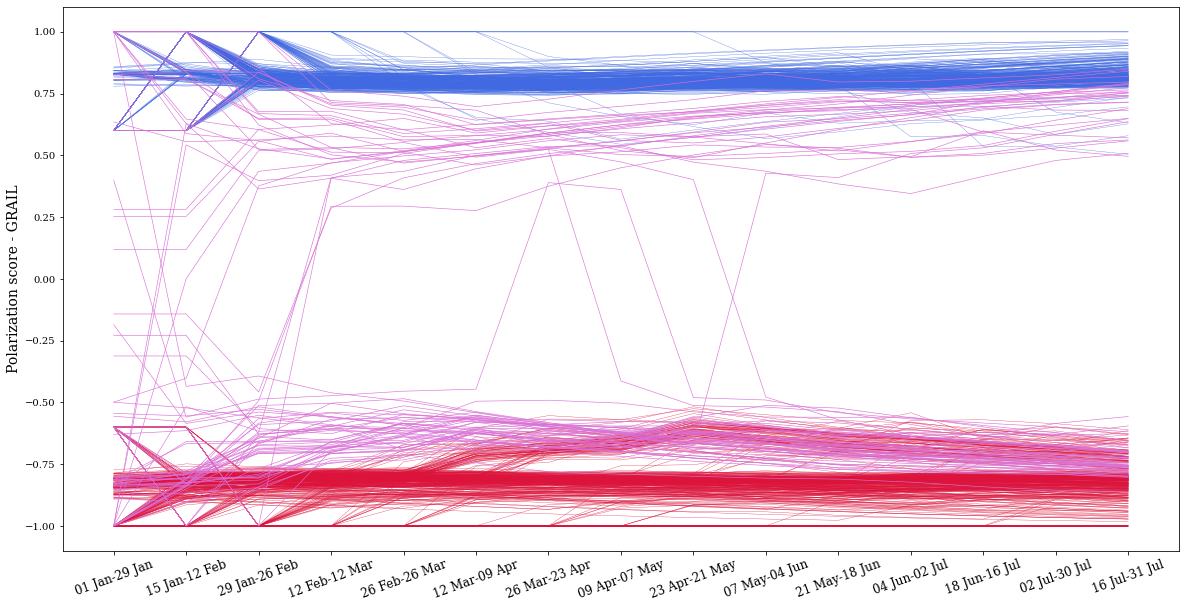

In [81]:
fig, ax = plt.subplots(figsize=(20,10))


#Vaccine
#ax.plot(GRAIL[provax_users],color='royalblue', linewidth=0.2)
#ax.plot(GRAIL[antivax_users],color='crimson', linewidth=0.2)

#Ukraine
ax.plot(GRAIL[proR_users],color='crimson', linewidth=0.3)
ax.plot(GRAIL[proU_users],color='royalblue', linewidth=0.3)
ax.plot(GRAIL[inter_users],color='orchid', linewidth=0.6)


ax.set_ylabel('Polarization score - GRAIL', fontsize=14)

labels = []
for p in range(len(periods)):
    label = periods[p][0].strftime('%d %b')+'-'+periods[p][1].strftime('%d %b')
    labels.append(label)
ax.set_xticks(np.arange(0,15,1),labels, rotation = 20, fontsize=12)
plt.show()

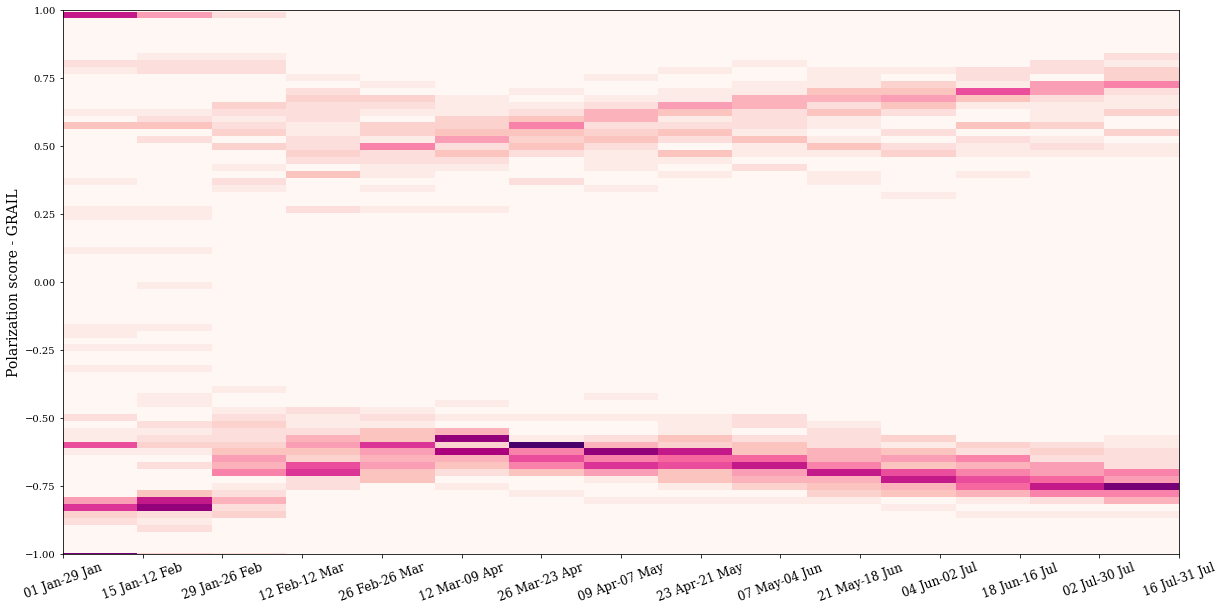

In [83]:
fig, ax = plt.subplots(figsize=(20,10))
im = dense_lines(ys=np.array(GRAIL[inter_users].T.values), x=np.array(GRAIL[inter_users].index), ax=ax, ny=80, cmap='RdPu')
ax.set_ylim(-1,1)
labels = []
for p in range(0,15,1):
    label = periods[p][0].strftime('%d %b')+'-'+periods[p][1].strftime('%d %b')
    labels.append(label)
ax.set_xticks(np.arange(0,15,1),labels, rotation = 20, fontsize=12)
ax.set_ylabel('Polarization score - GRAIL', fontsize=14)
plt.show()

## Time series clustering

In [70]:
grail_temporel_inter = GRAIL[inter_users].T

In [71]:
np_grail_inter = grail_temporel_inter.to_numpy()
np_grail_inter = np_grail_inter.reshape((len(grail_temporel_inter), 15, 1))

### Tuning of clustering algorithm parameters

In [72]:
k_range = [i for i in range(2, 7, 2)]
metrics = ['euclidean', 'dtw', 'softdtw']

In [73]:
def optimisation_kmeans(df, k_range_list, metrics_list):
    for k in k_range_list:
        for m in metrics_list:
            km = TimeSeriesKMeans(n_clusters=k, metric=m, max_iter=20).fit(df)
            sil = silhouette_score(df, km.labels_, metric=m)
            res = [('Number of clusters:', k), ('Metric:', m), ('Silhouette score:', sil)]
            print(res)

#### Utilisateurs inter

In [74]:
optimisation_kmeans(np_grail_inter, [i for i in range(2, 7, 1)], metrics)

[('Number of clusters:', 2), ('Metric:', 'euclidean'), ('Silhouette score:', 0.7891849833754329)]
[('Number of clusters:', 2), ('Metric:', 'dtw'), ('Silhouette score:', 0.80618968915195)]
[('Number of clusters:', 2), ('Metric:', 'softdtw'), ('Silhouette score:', 0.9253029229698342)]
[('Number of clusters:', 3), ('Metric:', 'euclidean'), ('Silhouette score:', 0.7346700547261549)]
[('Number of clusters:', 3), ('Metric:', 'dtw'), ('Silhouette score:', 0.7863195117524335)]
[('Number of clusters:', 3), ('Metric:', 'softdtw'), ('Silhouette score:', 0.8557072603632381)]
[('Number of clusters:', 4), ('Metric:', 'euclidean'), ('Silhouette score:', 0.7074940219818469)]
[('Number of clusters:', 4), ('Metric:', 'dtw'), ('Silhouette score:', 0.7629268785085861)]
[('Number of clusters:', 4), ('Metric:', 'softdtw'), ('Silhouette score:', 0.8605327429427507)]
[('Number of clusters:', 5), ('Metric:', 'euclidean'), ('Silhouette score:', 0.7087402971443874)]
[('Number of clusters:', 5), ('Metric:', 'dtw'

### Clustering with tuned parameters

In [75]:
def temporal_kmeans(np_data, df, k, metric):
    km = TimeSeriesKMeans(n_clusters=k, metric=metric,max_iter=20).fit(np_data)
    df['cluster_kmeans'] = km.labels_
    silhouette = silhouette_score(np_data, km.labels_, metric=metric)
    print(silhouette)
    return km

In [76]:
def plot_clusters_temp(df, km): 
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(df.iloc[:, :15].T, color='grey', linewidth=0.05)
    for i in range(km.cluster_centers_.shape[0]):
        ax.plot(km.cluster_centers_[i], linewidth = 3.0, label='cluster_'+str(i))
    ax.legend()
    ax.set_xlabel('Periods')
    ax.set_ylabel('GRAIL')
    ax.set_title('Evolution of oriented GRAIL alues over cumulative periods and clusters')
    labels = [i for i in range(1, 16, 1)]
    ax.set_xticks(np.arange(0,15,1),labels)
    plt.show()

In [82]:
def plot_clusters_temp_tendance(df, km): 
    fig, ax = plt.subplots(figsize=(20,10))
    #ax.plot(df.iloc[:, :15].T, color='grey', linewidth=0.05)
    for i in range(km.cluster_centers_.shape[0]):
        #ax.plot(km.cluster_centers_[i], linewidth = 3.0, label='cluster_'+str(i))
        cluster_sequences = np.array(df[km.labels_==i].iloc[:,:-1])
        for seq in cluster_sequences:
            plt.plot(seq.ravel(), color='grey', alpha=0.1)
        
        model = LinearRegression()
        model.fit(np.arange(len(cluster_sequences[0])).reshape(-1,1), cluster_sequences[0].ravel())
        print(model.score(np.arange(len(cluster_sequences[0])).reshape(-1,1), cluster_sequences[0].ravel()))
        trend_line = model.predict(np.arange(len(cluster_sequences[0])).reshape(-1,1))
        plt.plot(trend_line, 'r', linewidth=2)
    labels = [i for i in range(1, 16, 1)]
    ax.set_xticks(np.arange(0,15,1),labels)
    plt.xlabel('Periods')
    plt.ylabel('GRAIL')
    plt.title('Clusters')
    plt.show()

In [84]:
#Vaccine
km_inter = temporal_kmeans(np_grail_inter, grail_temporel_inter, 3, 'softdtw')

#Ukraine
km_inter = temporal_kmeans(np_grail_inter, grail_temporel_inter, 4, 'softdtw')

0.8605327429427507


In [85]:
grail_temporel_inter['cluster_kmeans'].value_counts()

0    44
1    20
2     8
3     4
Name: cluster_kmeans, dtype: int64

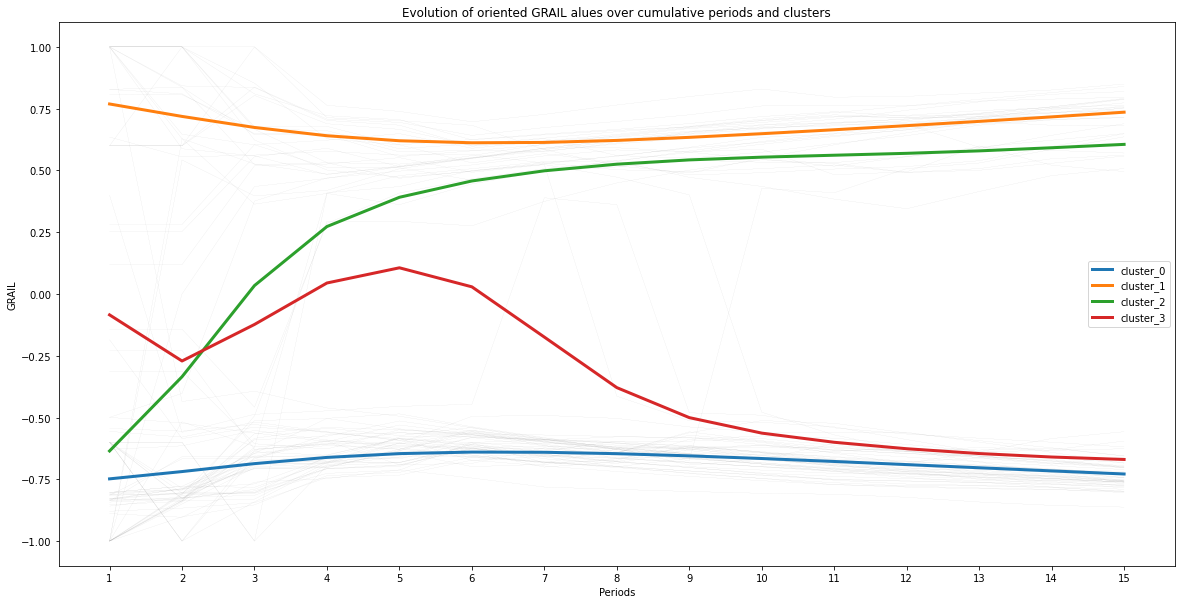

In [86]:
plot_clusters_temp(grail_temporel_inter, km_inter)

In [87]:
users_c0_var = grail_temporel_inter[grail_temporel_inter['cluster_kmeans']==0].index.tolist()
users_c1_var = grail_temporel_inter[grail_temporel_inter['cluster_kmeans']==1].index.tolist()
users_c2_var = grail_temporel_inter[grail_temporel_inter['cluster_kmeans']==2].index.tolist()
users_c3_var = grail_temporel_inter[grail_temporel_inter['cluster_kmeans']==3].index.tolist()

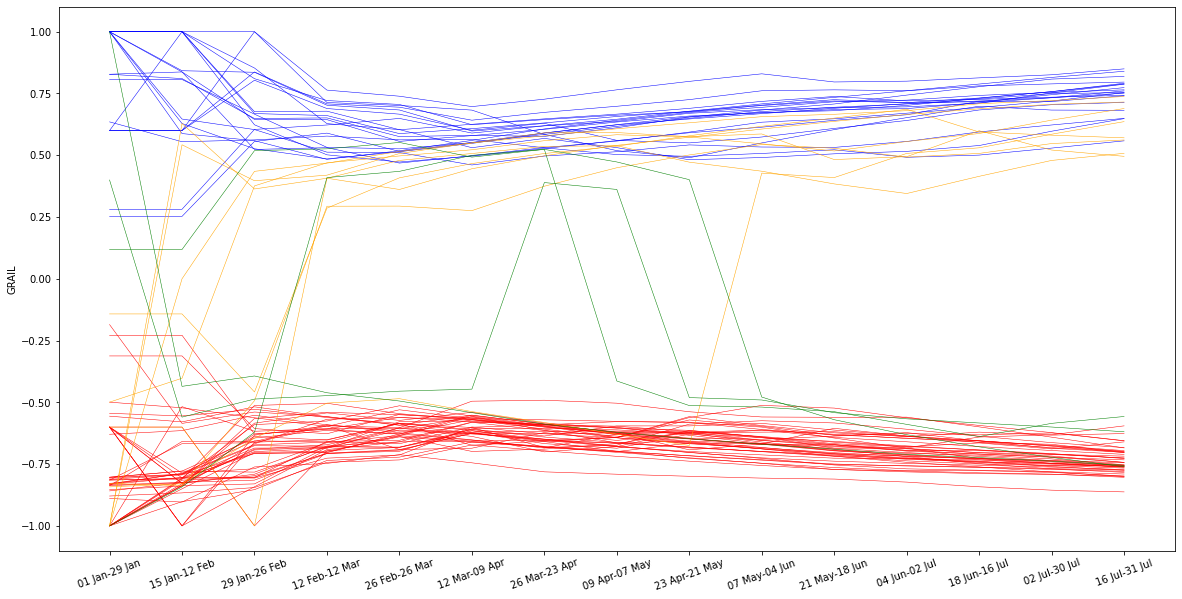

In [90]:
fig, ax = plt.subplots(figsize=(20,10))
colors = ['red','blue','orange','green']
for k in range(grail_temporel_inter['cluster_kmeans'].nunique()):
    df = grail_temporel_inter[grail_temporel_inter['cluster_kmeans']==k].iloc[:, :15].T
    ax.plot(df, color=colors[k], linewidth=0.5)
    ax.set_ylabel('GRAIL')
    labels = []
    for p in range(len(periods)):
        label = periods[p][0].strftime('%d %b')+'-'+periods[p][1].strftime('%d %b')
        labels.append(label)
    ax.set_xticks(np.arange(0,15,1),labels, rotation = 20)
plt.show()

Coeff [-0.0140462]
Interception -0.6507670785665107
R² 0.944049994193524
Coeff [0.02276576]
Interception 0.540622935235298
R² 0.9644257885371849


C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/1326228015.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(trend_line, 'r', color=colors[i], linewidth=2)
C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_17276/1326228015.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(trend_line, 'r', color=colors[i], linewidth=2)


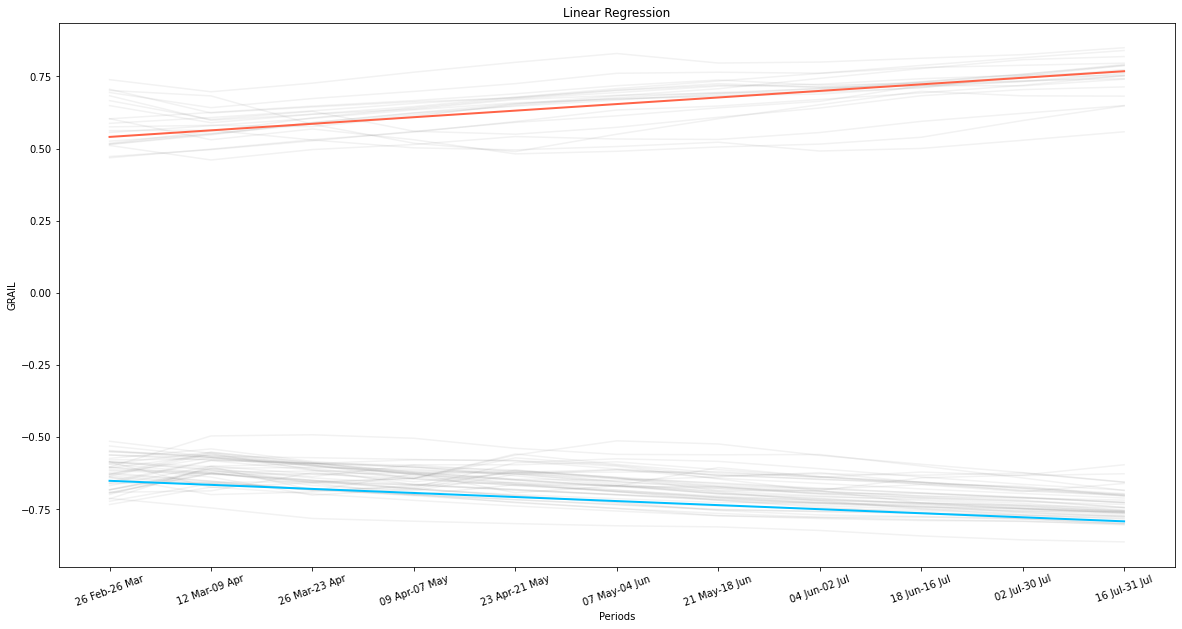

In [93]:
fig, ax = plt.subplots(figsize=(20,10))
#ax.plot(df.iloc[:, :15].T, color='grey', linewidth=0.05)
colors = {0:'deepskyblue', 1:'tomato'}
for i in [0,1]:
    #ax.plot(km.cluster_centers_[i], linewidth = 3.0, label='cluster_'+str(i))
    cluster_sequences = np.array(grail_temporel_inter[km_inter.labels_==i].iloc[:,4:-1])
    for seq in cluster_sequences:
        plt.plot(seq.ravel(), color='grey', alpha=0.1)
    
    model = LinearRegression()
    model.fit(np.arange(len(cluster_sequences[0])).reshape(-1,1), cluster_sequences[0].ravel())
    print('Coeff', model.coef_)
    print('Interception', model.intercept_)
    print('R²', model.score(np.arange(len(cluster_sequences[0])).reshape(-1,1), cluster_sequences[0].ravel()))
    trend_line = model.predict(np.arange(len(cluster_sequences[0])).reshape(-1,1))
    plt.plot(trend_line, 'r', color=colors[i], linewidth=2)
labels = []
for p in range(4,15,1):
    label = periods[p][0].strftime('%d %b')+'-'+periods[p][1].strftime('%d %b')
    labels.append(label)
ax.set_xticks(np.arange(0,11,1),labels, rotation = 20)
plt.xlabel('Periods')
plt.ylabel('GRAIL')
plt.title('Linear Regression')
plt.show()